# Data Science for Mobility / Intro to Business Analytics

# Lecture 8 - Adaptive parametric basis functions

In this notebook, we will see how adaptive parametric basis functions can be used to achieve complex decision boundaries for classification problems.

We begin by importing the packages that we will need later on...

In [13]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

%matplotlib inline
import matplotlib.pyplot as plt

#matplotlib style options
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 8)

If you haven't noticed yet, for some strange reason, it seems that we often need to run the commands for setting the matplotlib style options twice in order for them to take effect. So let's run them again, just to make sure:

In [14]:
#matplotlib style options
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 8)

## Load data

For the demo in this notebook, we will use some data that we previously prepared. It corresponds to a binary classification problem with just 2 features: X1 and X2. Let's load the data with Pandas and visualize it using Matplotlib:

In [5]:
# load demo dataset from file
df = pd.read_csv("demo_data.csv")
df.head()

,X1,X2,class
0,0.496714,-0.138264,0
1,0.647689,1.523030,0
2,-0.234153,-0.234137,0
3,1.579213,0.767435,0
4,-0.469474,0.542560,0


In [6]:
# extract features and targets as seperate numpy matrices/arrays
X = df[["X1","X2"]].to_numpy()
y_true = df["class"].to_numpy()
print("X shape:", X.shape)
print("y shape:", y_true.shape)

X shape: (200, 2)
y shape: (200,)


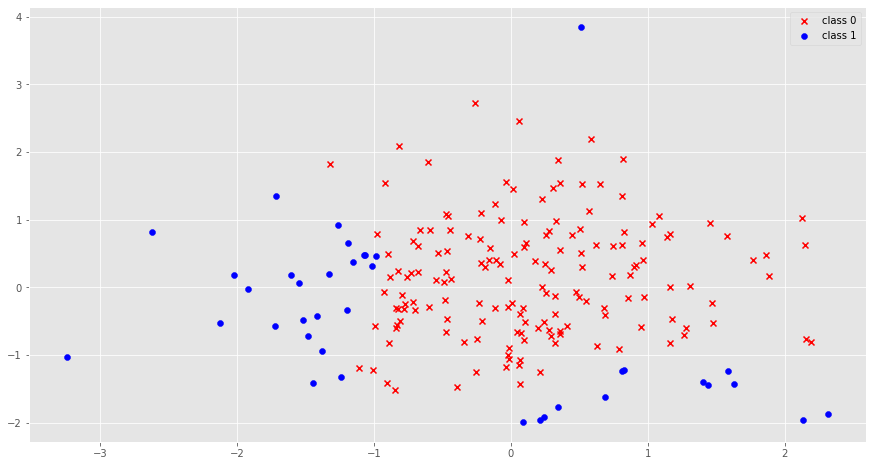

In [7]:
# visualize dataset and color points according to class
plt.scatter(X[y_true==0,0], X[y_true==0,1], marker='x', color="r")
plt.scatter(X[y_true==1,0], X[y_true==1,1], marker='o', color="b")
plt.legend(["class 0", "class 1"])
plt.show()

Imediately we can observe that the classes are not linearly separable! Indeed, any potential decision boundary that can separate the two classes would have to be quite complex.

But let's try to fit a simple logistic regression model in Sklearn anyway to see what decision boundaries it can achieve on this dataset. 

## Logistic regression model

Recall the logistic regression model is a linear model on the features X of the form:

\begin{align}
y = p(y_j=1)=\mbox{sigmoid}(\pmb{\beta}^T{\textbf{x}}_{\boldsymbol{j}})=\frac{\displaystyle 1}{\displaystyle 1+\exp(-\pmb{\beta}^T{\textbf{x}}_{\boldsymbol{j}})}
\end{align}

Two important notes:

1) Since we want to be able to visualize and study the decision boundaries, we will restrict all models to NOT FIT an intercept/bias term. Otherwise, the model will have 3 instead of 2 tunable parameters, and visualizing decision boundaries in 3D becomes way more complicated. In Sklearn, this can be done by passing the option "fit_intercept=False" to the LogisticRegression model.

2) In this case, we don't care about overfitting. In fact, we want our models to overfit a bit in order to study how complex the decision boundaries can really get. In Sklearn, this can be done by increasing the value of the "C" parameter of the LogisticRegression model. For example, C=10000.

Can you do it? Make sure to call your logistic regression model "reg", so that the rest of the code works!! :-)

In [7]:
# fit simple logistic regression model
reg = LogisticRegression(C=10000, fit_intercept=False)
reg.fit(X, y_true)

LogisticRegression(C=10000, fit_intercept=False)

What is the accuracy (on the trainset)? Can you calculate it? 

In [8]:
preds = reg.predict(X)
print("accuracy:", np.sum(preds == y_true).astype(float) / len(y_true))

accuracy: 0.62


Not very good, right? Is it surprising given how the dataset looks like and what the classes are?

Now, let's have a look at the decision boundary that the logistic regression model that you fitted induces:

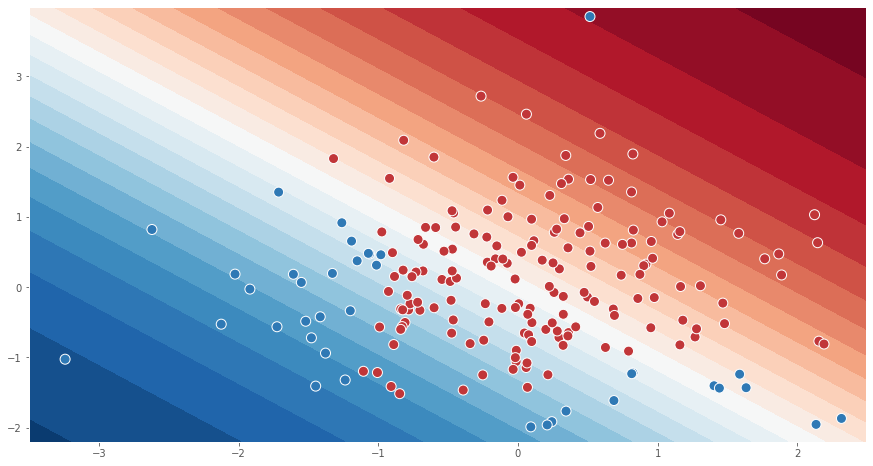

In [9]:
# create grid
xx1, xx2 = np.mgrid[-3.5:2.5:.01, -2.2:4:.01]
grid = np.c_[xx1.ravel(), xx2.ravel()]   #if you want to know what this is, inspect the "grid" variable,

# compute probabilities for all points in the grid
probs = reg.predict_proba(grid)[:,1]

# make plot
contour = plt.contourf(xx1, xx2, probs.reshape(xx1.shape), 25, cmap="RdBu", vmin=0, vmax=1)
plt.scatter(X[:,0], X[:, 1], c=y_true, s=100, cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white", linewidth=1)
plt.show()

In the plot above, the colors of the points indicate which class they truly belong to, and the shades/gradient colors in the background illustrate the probability of points in that area belonging to a given class. For example, the darker blue the color is, the more likely that area of the feature space is to belong to the blue class (according to the logistic regression model!). The decision boundary is then located in the line where red turns to blue. 

Well, given the assumption of the logistic regression model about the linearity of the decision boundary, the learned decision boundary makes sense, right? Can you come up with a linear decision boundary that does a better job than this?

## Basis functions

Ok, but in the end this is not a very good classifier. How can we do a better job at classifying? 

Basis functions! We can obtain arbitrarily complex decision boundaries if use the "right" basis functions $\phi(\textbf{x})$. The model can still be linear, but the basis transformations allow the decision boundary to be non-linear. 

\begin{align}
y=\color{blue}{ \mbox{sigmoid}\Bigg(b + \sum_{m=1}^M w_m } \, \color{red}{ {\phi}_m (\textbf{x}) } \color{blue}{ \Bigg) }
\end{align}

But how can come up with "good" basis functions $\phi(\textbf{x})$? There are different approaches:

- **Manual feature engineering.** If you have good domain knowledge that you can exploit to come up with good features that make it easier for the model to discriminate between classes, then this is a good option. The problem is that it can be very time-consuming, and the number of extra features may end up being too high - leads to the curse of dimensionality...

- **Kernel trick.** You can augment the feature space using for example a Gaussian RBF kernel, as typically done in SVMs. But where to place the centers of the inducing points? And how many? By default, we commonly assume that each data point in X is also a center. But then we have as many basis functions (and parameters to tune!) as training points! Overfitting is bound to be severe. This is where SVMs do something very clever, and only keep a subset of inducing points that are helpful for maximizing the margin between classes - called the "support vectors". But the size of this subset still typically grows with the size of the dataset... :-(

- **Adaptive parametric basis functions.** We fix the number of basis functions in advance! BUT, we allowed them to be adaptive. How? Define them using a (non-linear) parametric form, in which the parameters of the basis functions are adapted during training. We will discuss later how to train them, but this is what neural networks do! 

\begin{align}
y=\color{blue}{ \mbox{sigmoid}\Bigg( b + \sum_{m=1}^M w_m} \, \color{red}{ g\bigg(b_{m} + \sum_{i=1}^D w_{m,i} x_i \bigg) } \color{blue}{ \Bigg) }
\end{align}

We can write the part in red more compactly using matrix notation: 

\begin{align}
\color{red}{ \textbf{h} = g(\textbf{b} + \textbf{x} \textbf{W}) }
\end{align}

We can also think of this visually by representing the operations in graph (network):

_ 

<div>
<img src="http://mlsm.man.dtu.dk/wp-content/uploads/2019/10/nn_basis-1.png" width="300"/>
</div>

As mentioned above, the goal is to learn the parameters of basis transformation in red. However, for the purpose of this notebook tutorial, we will consider them to be given in advance. Just so that we can see their potential...

Here are the values of $\textbf{W}$ and $\textbf{b}$ given in advance:

In [10]:
# parameters of the basis functions
W = np.array([[-1.53411417,  1.27767682,  0.33231401, -0.74848654],
              [ 1.55115198,  0.11567463,  1.17929718,  0.06751848]])
print("W shape:", W.shape)
b = np.array([-1.59442766, -0.59937502,  0.0052437 ,  0.04698059])
print("b shape:", b.shape)

W shape: (2, 4)
b shape: (4,)


Notice the dimensions of $\textbf{W}$ and $\textbf{b}$. We have a-priori fixed the number of basis functions to be 4. Of course, we could have used a different number...

Now, we use these parameters to compute the transformed features $\textbf{h}$. You can think of $\textbf{h}$ as a re-representation (non-linear tranformation) of the original features $\textbf{X}$ in a higher-dimensional space. In this case, the original space of $\textbf{X}$ was 2-dimensional, while the transformed space is 4-dimensional.

Can you calculate $\textbf{h}$?

In [11]:
# sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [12]:
# compute basis transformation of the original features X
h = sigmoid(b + np.dot(X,W))
print("h shape:", h.shape)

h shape: (200, 4)


Check the dimensions/shape of $\textbf{h}$. Does it make sense?

You can also have a look at the values of $\textbf{h}$...

In [13]:
print(h)

[[7.10340448e-02 5.04817718e-01 5.01813510e-01 4.17233965e-01]
 [4.43836751e-01 5.99729350e-01 8.82527376e-01 4.17031134e-01]
 [1.68206523e-01 2.83811917e-01 4.13701147e-01 5.51425673e-01]
 [5.58976354e-02 8.18634194e-01 8.07690340e-01 2.52896594e-01]
 [4.91848906e-01 2.42972534e-01 6.19887398e-01 6.07069058e-01]
 [1.67157281e-01 2.23506777e-01 3.32257960e-01 5.89620588e-01]
 [7.15037901e-03 3.74831782e-01 1.02414981e-01 4.34551026e-01]
 [5.44779650e-01 5.37427876e-02 2.25993373e-01 7.85850730e-01]
 [6.09882011e-01 1.35041964e-01 5.09812920e-01 6.95569592e-01]
 [8.37761201e-02 1.27538078e-01 1.23247394e-01 6.52776874e-01]
 [1.48746047e-02 7.76803322e-01 5.56271098e-01 2.56301379e-01]
 [1.96848537e-02 3.36729488e-01 1.60769026e-01 4.75080615e-01]
 [3.57271910e-01 2.17194792e-01 4.88788977e-01 6.13472651e-01]
 [6.80069806e-01 1.16447097e-01 5.16447070e-01 7.17855785e-01]
 [2.45003490e-01 1.97730639e-01 3.68571366e-01 6.17005154e-01]
 [9.00413183e-01 2.39777450e-01 8.79708708e-01 6.507671

Ok, so now we have a transformed version of $\textbf{X}$. Let's try to fit a simple logistic regression classifier to this new representation of the data (use the same value of "C" as before, and also use "fit_intercept=False"). Make sure to call your logistic regression model variable "reg" for the rest of the code to work :-)

In [14]:
# fit simple logistic regression model
reg = LogisticRegression(C=10000, fit_intercept=False)
reg.fit(h, y_true)

LogisticRegression(C=10000, fit_intercept=False)

What is the accuracy (on the trainset)? Can you calculate it? 

In [15]:
preds = reg.predict(h)
print("accuracy:", np.sum(preds == y_true).astype(float) / len(y_true))

accuracy: 1.0


Much better, right? 

Now let's have a look at the decision boundary that the new logistic regression classifier based on the new transformed features induces:

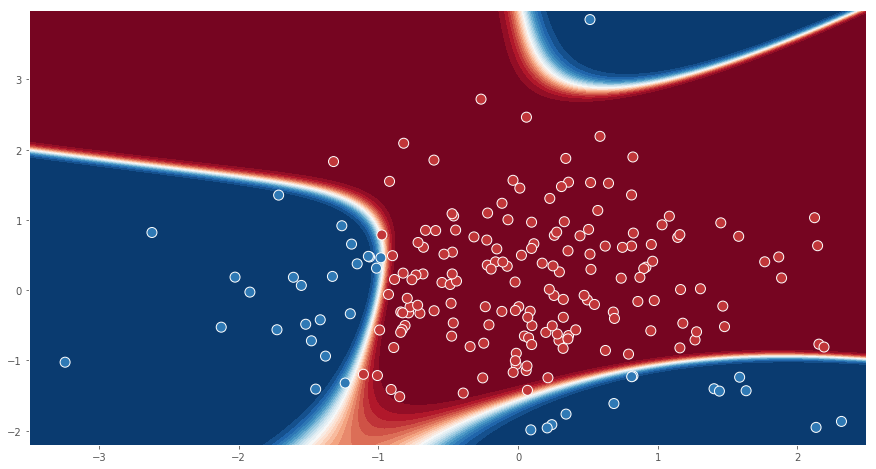

In [15]:
# create grid
xx1, xx2 = np.mgrid[-3.5:2.5:.01, -2.2:4:.01]
grid = np.c_[xx1.ravel(), xx2.ravel()]   #if you want to know what this is, inspect the "grid" variable,

# compute probabilities for all points in the grid
h_grid = sigmoid(b + np.dot(grid,W))
probs = reg.predict_proba(h_grid)[:,1]

# make plot
contour = plt.contourf(xx1, xx2, probs.reshape(xx1.shape), 25, cmap="RdBu", vmin=0, vmax=1)
plt.scatter(X[:,0], X[:, 1], c=y_true, s=100, cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white", linewidth=1)
plt.show()

Cool, right? Quite a complex decision boundary!

Try playing with the values of "C" in the logistic regression classier and see how it affects the accuracy and the fuzzyness of the decision boundary :-)